In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
import numpy as np
from scipy.stats import randint, uniform
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

In [5]:
# Séparation des données et choix des features

df = pd.read_csv('season_data_preprocessed.csv')

features_to_keep = ["LapNumber", "TyreLife", "Compound", "FreshTyre", "LapTime", "Sector1Time",
    "Sector2Time", "Sector3Time", "SpeedI1", "SpeedI2", "SpeedFL",
    "SpeedST", "Position", "AirTemp", "TrackTemp", "WindSpeed", 'Humidity',
    "TrackStatus", "LapsRemaining"]

X = df[features_to_keep]
y = df['PitStopNextLap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Données préparées : {X_train.shape[0]} échantillons pour l'entraînement, {X_test.shape[0]} pour le test.")


✅ Données préparées : 2244 échantillons pour l'entraînement, 562 pour le test.


In [6]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"✅ Données préparées et rééquilibré !")


✅ Données préparées et rééquilibré !


In [7]:
# RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_resampled, y_train_resampled)

y_pred = rf_model.predict(X_test)

print("📊 Rapport de classification avec balanced:\n", classification_report(y_test, y_pred))
print("✅ Accuracy :", accuracy_score(y_test, y_pred))

📊 Rapport de classification avec balanced:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       474
           1       0.60      0.64      0.62        88

    accuracy                           0.88       562
   macro avg       0.77      0.78      0.77       562
weighted avg       0.88      0.88      0.88       562

✅ Accuracy : 0.8772241992882562


In [8]:
# Utilisation de GridSearch pour trouver les meilleurs paramètres

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 25, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

print("✅ Meilleurs paramètres :", grid_search.best_params_)

best_model = grid_search.best_estimator_

✅ Meilleurs paramètres : {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


📊 Rapport de classification (avec SMOTE) :
 {'0': {'precision': 0.9358974358974359, 'recall': 0.9240506329113924, 'f1-score': 0.9299363057324841, 'support': 474.0}, '1': {'precision': 0.6170212765957447, 'recall': 0.6590909090909091, 'f1-score': 0.6373626373626373, 'support': 88.0}, 'accuracy': 0.8825622775800712, 'macro avg': {'precision': 0.7764593562465902, 'recall': 0.7915707710011508, 'f1-score': 0.7836494715475607, 'support': 562.0}, 'weighted avg': {'precision': 0.8859666493875626, 'recall': 0.8825622775800712, 'f1-score': 0.8841240587279529, 'support': 562.0}}


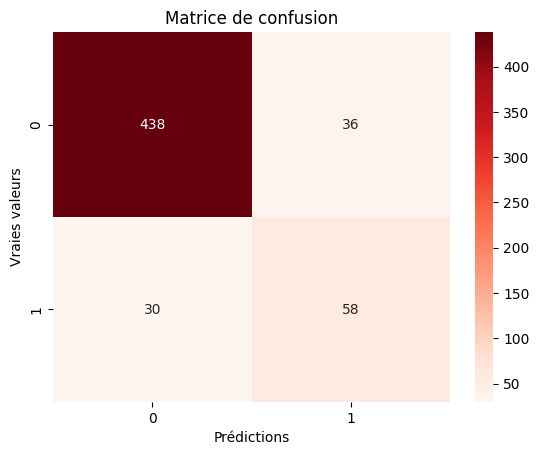

In [9]:
# Réentraîner le modèle optimisé sur les données rééquilibrées
best_model = RandomForestClassifier(
    max_depth=20, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=200, 
    random_state=42, 
)

best_model.fit(X_train_resampled, y_train_resampled)
y_pred_smote = best_model.predict(X_test)

conf_mat_rf = confusion_matrix(y_test, y_pred_smote)
class_report_rf = classification_report(y_test, y_pred_smote, output_dict=True)

print("📊 Rapport de classification (avec SMOTE) :\n", class_report_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

In [10]:
# DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

y_pred_dt_model = dt_model.predict(X_test)
print("📊 Decision Tree:\n", classification_report(y_test, y_pred_dt_model))

📊 Decision Tree:
               precision    recall  f1-score   support

           0       0.91      0.85      0.88       474
           1       0.41      0.57      0.48        88

    accuracy                           0.81       562
   macro avg       0.66      0.71      0.68       562
weighted avg       0.84      0.81      0.82       562



In [11]:
# Utilisation de GridSearch pour trouver les meilleurs params

tree_param = [
    {
        'criterion': ['entropy', 'gini'],  
        'max_depth': list(range(5, 20, 2))  
    },
    {
        'min_samples_leaf': list(range(2, 20, 2)),  
        'min_samples_split': [2, 5, 10]  
    }
]

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param, cv=5, scoring='f1')
grid_search_dt.fit(X_train_resampled, y_train_resampled)

print("✅ Meilleurs paramètres :", grid_search_dt.best_params_)
print(f'Meilleur score AUC : {grid_search_dt.best_score_}')



✅ Meilleurs paramètres : {'criterion': 'entropy', 'max_depth': 17}
Meilleur score AUC : 0.8822633638138001


In [12]:
rand_search_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), tree_param, cv=5, n_jobs=-1)
rand_search_dt.fit(X_train_resampled, y_train_resampled)

print("✅ Meilleurs paramètres :", rand_search_dt.best_params_)
print(f'Meilleur score AUC : {rand_search_dt.best_score_}')



✅ Meilleurs paramètres : {'max_depth': 13, 'criterion': 'entropy'}
Meilleur score AUC : 0.873596217021954


📊 Rapport de classification (modèle optimisé) :
 {'0': {'precision': 0.9142857142857143, 'recall': 0.8776371308016878, 'f1-score': 0.8955866523143164, 'support': 474.0}, '1': {'precision': 0.45794392523364486, 'recall': 0.5568181818181818, 'f1-score': 0.5025641025641026, 'support': 88.0}, 'accuracy': 0.8274021352313167, 'macro avg': {'precision': 0.6861148197596796, 'recall': 0.7172276563099348, 'f1-score': 0.6990753774392096, 'support': 562.0}, 'weighted avg': {'precision': 0.8428300604839667, 'recall': 0.8274021352313167, 'f1-score': 0.8340457548445321, 'support': 562.0}}


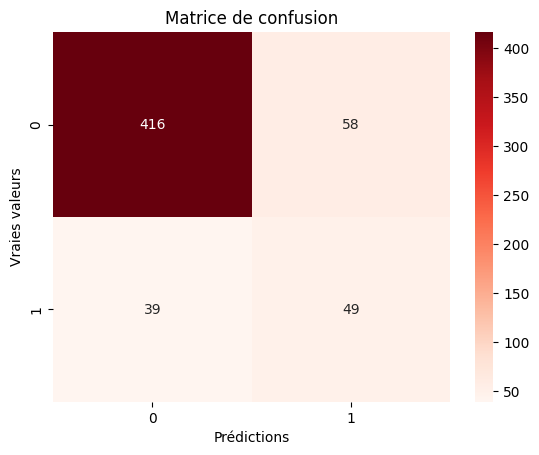

In [13]:
best_model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=17)
best_model_dt.fit(X_train_resampled, y_train_resampled)

y_pred_best_dt = best_model_dt.predict(X_test)

conf_mat_dt_rand = confusion_matrix(y_test, y_pred_best_dt)
class_report_dt_rand = classification_report(y_test, y_pred_best_dt, output_dict=True)

print("📊 Rapport de classification (modèle optimisé) :\n", class_report_dt_rand)

sns.heatmap(conf_mat_dt_rand, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

In [14]:
# LightGBM

lgb_model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

lgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_lgb = lgb_model.predict(X_test)
print("📊 Decision Tree:\n", classification_report(y_test, y_pred_lgb))


📊 Decision Tree:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       474
           1       0.65      0.65      0.65        88

    accuracy                           0.89       562
   macro avg       0.79      0.79      0.79       562
weighted avg       0.89      0.89      0.89       562



In [15]:
# GridSearchCV with LightLGBM
param_grid_lgb = {
    'num_leaves': randint(20, 70),  
    'max_depth': randint(3, 10),    
    'learning_rate': uniform(0.01, 0.2), 
    'n_estimators': randint(50, 300),  
    'min_child_samples': randint(5, 50),
    'subsample': uniform(0.6, 0.4),  
    'colsample_bytree': uniform(0.6, 0.4),  
    'reg_lambda': uniform(0, 10),    
    'reg_alpha': uniform(0, 10)      
}

grid_search_lgb = RandomizedSearchCV(LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1), param_grid_lgb, cv=5, scoring='f1', n_jobs=-1, random_state=42)

grid_search_lgb.fit(X_train_resampled, y_train_resampled)
print("✅ Meilleurs paramètres :", grid_search_lgb.best_params_)
print(f'Meilleur score AUC : {grid_search_lgb.best_score_}')


✅ Meilleurs paramètres : {'colsample_bytree': np.float64(0.7579526072702278), 'learning_rate': np.float64(0.06869763494360763), 'max_depth': 9, 'min_child_samples': 15, 'n_estimators': 292, 'num_leaves': 36, 'reg_alpha': np.float64(7.113419527486499), 'reg_lambda': np.float64(7.9017554053120564), 'subsample': np.float64(0.8423839899124046)}
Meilleur score AUC : 0.8993373814882197


📊 Rapport de classification (modèle optimisé) :
 {'0': {'precision': 0.9392624728850325, 'recall': 0.9135021097046413, 'f1-score': 0.9262032085561497, 'support': 474.0}, '1': {'precision': 0.594059405940594, 'recall': 0.6818181818181818, 'f1-score': 0.6349206349206349, 'support': 88.0}, 'accuracy': 0.8772241992882562, 'macro avg': {'precision': 0.7666609394128132, 'recall': 0.7976601457614115, 'f1-score': 0.7805619217383923, 'support': 562.0}, 'weighted avg': {'precision': 0.8852093236125937, 'recall': 0.8772241992882562, 'f1-score': 0.8805931258516563, 'support': 562.0}}


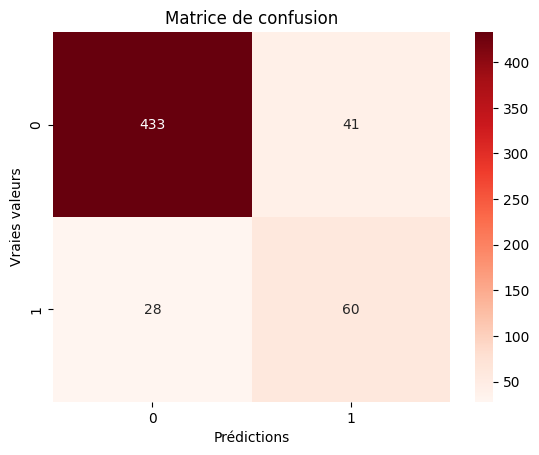

In [16]:
# Best model LightLGBM

best_model_lgb = LGBMClassifier(colsample_bytree=0.75, learning_rate=0.06, max_depth=9,
               min_child_samples=15, n_estimators=292, n_jobs=-1, num_leaves=36,
               random_state=42, reg_alpha=7.11, reg_lambda=7.90, subsample=0.84,
               verbose=-1)

best_model_lgb.fit(X_train_resampled, y_train_resampled)

y_pred_best_lgb = best_model_lgb.predict(X_test)

conf_mat_lgb = confusion_matrix(y_test, y_pred_best_lgb)
class_report_lgb = classification_report(y_test, y_pred_best_lgb, output_dict=True)

print("📊 Rapport de classification (modèle optimisé) :\n", class_report_lgb)
sns.heatmap(conf_mat_lgb, annot=True, fmt='d', cmap='Reds')
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

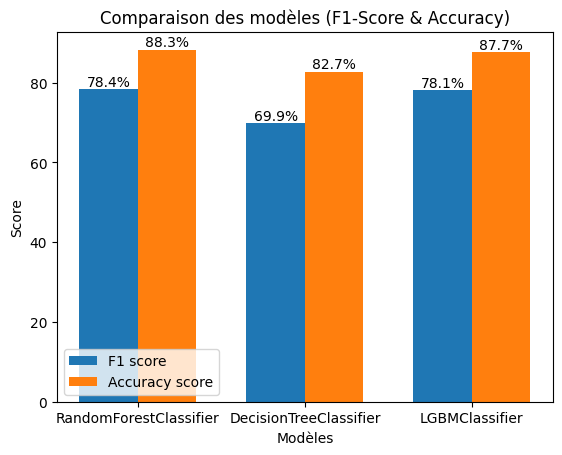

In [17]:
# Comparaison des différents modèles optimisés (Acc, F1-score)
rf_f1_score = class_report_rf['macro avg']['f1-score']
dt_f1_score = class_report_dt_rand['macro avg']['f1-score']
lgb_f1_score = class_report_lgb['macro avg']['f1-score']

rf_acc_score = class_report_rf['accuracy']
dt_acc_score = class_report_dt_rand['accuracy']
lgb_acc_score = class_report_lgb['accuracy']

models = ['RandomForestClassifier', 'DecisionTreeClassifier', 'LGBMClassifier']


f1_scores = [rf_f1_score, dt_f1_score, lgb_f1_score]
accuracy_scores = [rf_acc_score, dt_acc_score, lgb_acc_score]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, [s * 100 for s in f1_scores], width, label='F1 score')
bars2 = ax.bar(x + width/2, [s * 100 for s in accuracy_scores], width, label='Accuracy score')

ax.bar_label(bars1, fmt='{:.1f}%')
ax.bar_label(bars2, fmt='{:.1f}%')

ax.set_xlabel("Modèles")
ax.set_ylabel('Score')
ax.set_title("Comparaison des modèles (F1-Score & Accuracy)")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower left')

plt.show()

In [18]:
# push model LGBMClassifier to mlflow

mlflow.set_tracking_uri('http://127.0.0.1:5001')

with mlflow.start_run():
    mlflow.log_param("colsample_bytree", 0.75)
    mlflow.log_param("learning_rate", 0.06)
    mlflow.log_param("max_depth", 9)
    mlflow.log_param("min_child_samples", 15)
    mlflow.log_param("n_estimators", 292)
    mlflow.log_param("num_leaves", 36)
    mlflow.log_param("reg_alpha", 7.11)
    mlflow.log_param("reg_lambda", 7.90)
    mlflow.log_param("subsample", 0.84)
    # Log des metric
    mlflow.log_metric("accuracy", lgb_acc_score)

    # Log des features utilisées
    mlflow.log_param("features", str(features_to_keep))
    mlflow.lightgbm.log_model(best_model_lgb, 'LGBMClassifier')
    

2025/03/18 00:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run placid-slug-547 at: http://127.0.0.1:5001/#/experiments/0/runs/e9e8cc687f82437cb7ac1d6d422d70b4
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/0


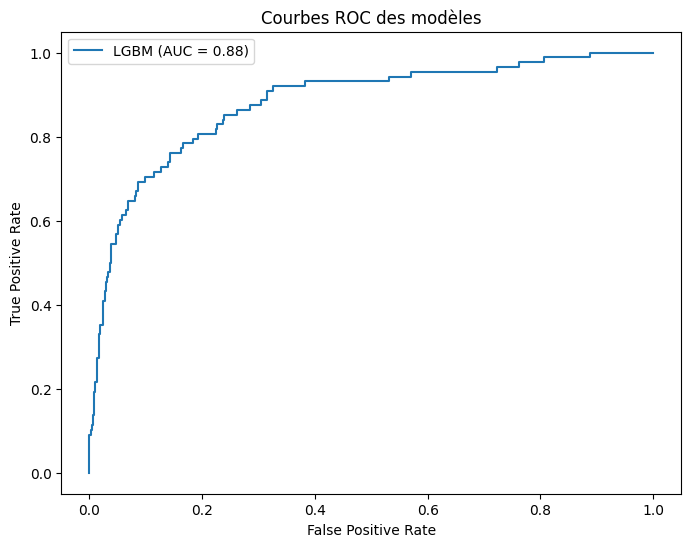

In [19]:
# utiliser randomforest -> faire tourner et comparer données tests et prédites
df_resultat_prediction = pd.read_csv('resultat_prediction.csv')

plt.figure(figsize=(8, 6))

# RandomForestClassifier
lgb_probs = best_model_lgb.predict_proba(X_test)[:, 1]

# LGBM
fpr, tpr, _ = roc_curve(y_test, lgb_probs)
plt.plot(fpr, tpr, label=f"LGBM (AUC = {auc(fpr, tpr):.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbes ROC des modèles")
plt.legend()
plt.show()

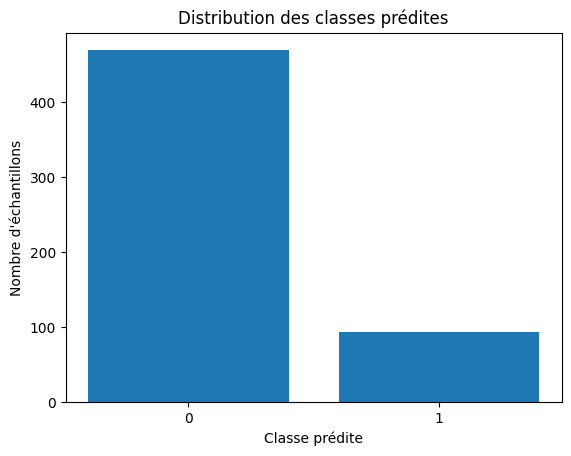

In [20]:
unique, counts = np.unique(y_pred, return_counts=True)
plt.bar(unique, counts)
plt.xticks([0, 1])
plt.xlabel("Classe prédite")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des classes prédites")
plt.show()

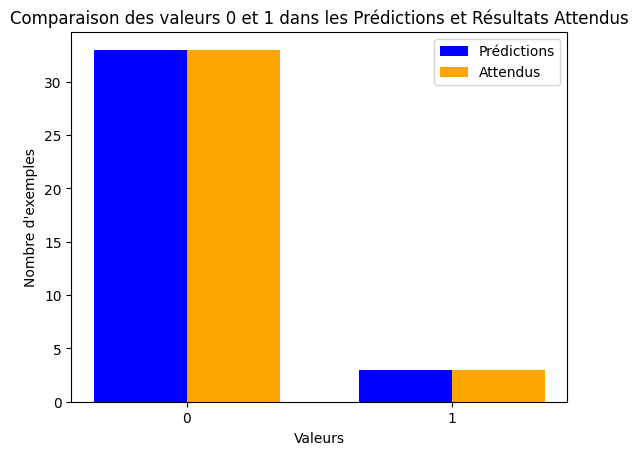

In [38]:
df_res = pd.read_csv('resultat_prediction.csv')
df_res_att = pd.read_csv('nor-extended-data-preprocessed.csv')

pred_res = np.sum(df_res['prediction'] == 0)
pred_res_att = np.sum(df_res_att['PitStopNextLap'] == 1)

att_res = np.sum(df_res['prediction'] == 0)
att_res_att = np.sum(df_res_att['PitStopNextLap'] == 1)

# Labels et valeurs pour chaque liste
labels = ['0', '1']
pred_values = [pred_res, pred_res_att]
att_values = [att_res, att_res_att]

# Position des barres
x = np.arange(len(labels))

# Création du graphique
width = 0.35  # Largeur des barres
fig, ax = plt.subplots()

# Barres pour les résultats de la prédiction et les résultats attendus
bar1 = ax.bar(x - width/2, pred_values, width, label='Prédictions', color='blue')
bar2 = ax.bar(x + width/2, att_values, width, label='Attendus', color='orange')

# Ajout de labels et titre
ax.set_xlabel("Valeurs")
ax.set_ylabel("Nombre d'exemples")
ax.set_title("Comparaison des valeurs 0 et 1 dans les Prédictions et Résultats Attendus")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Affichage du graphique
plt.show()